In [21]:
import pandas as pd
import numpy as np
import json
pd.set_option('display.max_columns', 500)

# df = pd.read_csv("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_raw/eth_cbbtc_usdt.csv")
# df = pd.read_csv("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_enriched/eth_cbbtc_usdt.csv")
df = pd.read_csv("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/markets_enriched/eth_cbbtc_usdc.csv")

with open("/Users/yegortrussov/Documents/ml/lending_protocols/dataset_collection/data/common/markets_meta.json", 'r') as f:
    markets_meta = json.load(f)
market_meta = markets_meta["0x45671fb8d5dea1c4fbca0b8548ad742f6643300eeb8dbd34ad64a658b2b05bca"]

market_meta.keys()

dict_keys(['address', 'lltv', 'oracle_address', 'creation_datetime', 'network', 'loan_asset_address', 'loan_asset_symbol', 'loan_asset_decimals', 'collateral_asset_address', 'collateral_asset_symbol', 'collateral_asset_decimals', 'irm_curve'])

In [16]:
df.head(3)
# df["assets_usd"].describe()
# df["type"].unique()
# df["collateral_price"].isna().sum()

,hash,type,timestamp,user_address,assets,assets_usd,market,datetime,market_address,total_supply_before,total_borrow_before,total_supply_after,total_borrow_after,utilization_before,utilization_after,tx_actions,borrow_rate_before,supply_rate_before,borrow_rate_after,supply_rate_after,collateral_price,loan_asset_price,collateral_before,collateral_value_before,debt_before,ltv_before,collateral_after,collateral_value_after,debt_after,ltv_after,health_factor_before,health_factor_after
0,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketSupply,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,1000000,0.999934,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,0.0,0.0,1.0,0.89,0.0,0.89,3,0.010097,0.0,0.040662,0.036189,NaN,0.999641,0.0,NaN,0.0,0.0,0.00005,NaN,0.88968,0.0,0.0,0.0
1,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketSupplyCollateral,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,5000,2.903950,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,0.0,0.0,1.0,0.89,0.0,0.89,3,0.010097,0.0,0.040662,0.036189,NaN,0.999641,0.0,NaN,0.0,0.0,0.00005,NaN,0.88968,0.0,0.0,0.0
2,0x55b1f9bfe77fa41b9f74b6949024ed40c61fda35554c...,MarketBorrow,1726145495,0x29d4CDFee8F533af8529A9e1517b580E022874f7,890000,0.889941,eth_cbbtc_usdc,2024-09-12 12:51:35,0x64d65c9a2d91c36d56fbc42d69e979335320169b3df6...,0.0,0.0,1.0,0.89,0.0,0.89,3,0.010097,0.0,0.040662,0.036189,NaN,0.999641,0.0,NaN,0.0,0.0,0.00005,NaN,0.88968,0.0,0.0,0.0


In [17]:
def create_user_features(df, user_address):
    user_df = df[df['user_address'] == user_address].copy()
    
    if user_df.empty:
        return pd.Series({
            'total_lifetime_volume': 0,
            'activity_frequency_days': None,
            'churn_rate': None,
            'session_intensity': 0,
            'tenure_days': 0,
            'avg_borrow_ltv': None, 'max_borrow_ltv': None,
            'min_borrow_hf': None, 'avg_borrow_hf': None,
            'avg_repay_ltv': None, 'max_repay_ltv': None, 'min_repay_ltv': None,
            'min_repay_hf': None, 'avg_repay_hf': None,
            'supply_collateral_count': 0, 'repay_count': 0, 'borrow_count': 0,
            'max_debt_after': 0, 'max_collateral_after': 0
        })
    
    user_df = user_df.sort_values('timestamp')
    
    # Transaction type masks
    supply_mask = user_df['type'] == 'MarketSupply'
    supply_collateral_mask = user_df['type'] == 'MarketSupplyCollateral'
    borrow_mask = user_df['type'] == 'MarketBorrow'
    repay_mask = user_df['type'] == 'MarketRepay'
    withdraw_mask = user_df['type'] == 'MarketWithdraw'
    withdraw_collateral_mask = user_df['type'] == 'MarketWithdrawCollateral'
    
    # Total Lifetime Volume
    total_volume = user_df.loc[supply_mask, 'assets_usd'].sum() + \
                   user_df.loc[borrow_mask, 'assets_usd'].sum()
    
    # Activity Frequency and Tenure
    first_action = user_df['timestamp'].min()
    last_action = user_df['timestamp'].max()
    tenure_days = (last_action - first_action) / (24 * 3600)
    
    if len(user_df) > 1:
        time_diffs = user_df['timestamp'].diff().dropna()
        activity_frequency = time_diffs.mean() / (24 * 3600)
        churn_rate = 1 / activity_frequency if activity_frequency > 0 else None
    else:
        activity_frequency = churn_rate = None
    
    # Session Intensity
    active_days = user_df['datetime'].dt.date.nunique()
    session_intensity = len(user_df) / active_days if active_days > 0 else 0
    
    # LTV and Health Factor calculations
    # Health Factor = 1 / LTV (when LTV > 0)
    borrow_df = user_df[borrow_mask]
    repay_df = user_df[repay_mask]
    
    # Borrow statistics
    borrow_ltv = borrow_df['ltv_after']
    avg_borrow_ltv = borrow_ltv.mean() if not borrow_ltv.empty else None
    max_borrow_ltv = borrow_ltv.max() if not borrow_ltv.empty else None
    
    # Health factor for borrows (1/LTV when LTV > 0)
    borrow_hf = 1 / borrow_ltv[borrow_ltv > 0]
    min_borrow_hf = borrow_hf.min() if not borrow_hf.empty else None
    avg_borrow_hf = borrow_hf.mean() if not borrow_hf.empty else None
    
    # Repay statistics
    repay_ltv = repay_df['ltv_after']
    avg_repay_ltv = repay_ltv.mean() if not repay_ltv.empty else None
    max_repay_ltv = repay_ltv.max() if not repay_ltv.empty else None
    min_repay_ltv = repay_ltv.min() if not repay_ltv.empty else None
    
    # Health factor for repays
    repay_hf = 1 / repay_ltv[repay_ltv > 0]
    min_repay_hf = repay_hf.min() if not repay_hf.empty else None
    avg_repay_hf = repay_hf.mean() if not repay_hf.empty else None
    
    # Event counts
    supply_collateral_count = supply_collateral_mask.sum()
    repay_count = repay_mask.sum()
    borrow_count = borrow_mask.sum()
    
    # Maximum values
    max_debt_after = user_df['debt_after'].max()
    max_collateral_after = user_df['collateral_after'].max()
    
    return pd.Series({
        'total_lifetime_volume': total_volume,
        'activity_frequency_days': activity_frequency,
        'churn_rate': churn_rate,
        'session_intensity': session_intensity,
        'tenure_days': tenure_days,
        'avg_borrow_ltv': avg_borrow_ltv,
        'max_borrow_ltv': max_borrow_ltv,
        'min_borrow_hf': min_borrow_hf,
        'avg_borrow_hf': avg_borrow_hf,
        'avg_repay_ltv': avg_repay_ltv,
        'max_repay_ltv': max_repay_ltv,
        'min_repay_ltv': min_repay_ltv,
        'min_repay_hf': min_repay_hf,
        'avg_repay_hf': avg_repay_hf,
        'supply_collateral_count': supply_collateral_count,
        'repay_count': repay_count,
        'borrow_count': borrow_count,
        'max_debt_after': max_debt_after,
        'max_collateral_after': max_collateral_after
    })

def create_all_user_features(df):
    if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
        df['datetime'] = pd.to_datetime(df['datetime'])
    
    user_features = df.groupby('user_address').apply(
        lambda x: create_user_features(df, x.name)
    )
    
    return user_features.reset_index()

In [55]:
COLUMNS_TO_LEAVE = [
    'user_address',
    'total_lifetime_volume',
    'activity_frequency_days',
    'churn_rate',
    'session_intensity',
    # 'tenure_days',
    # 'avg_borrow_ltv',
    'max_borrow_ltv',
    # 'min_borrow_hf',
    # 'avg_borrow_hf',
    # 'avg_repay_ltv',
    'max_repay_ltv',
    # 'min_repay_ltv',
    # 'min_repay_hf',
    # 'avg_repay_hf',
    'supply_collateral_count',
    'repay_count',
    'borrow_count',
    # 'max_debt_after',
    # 'max_collateral_after'
]
features_df = create_all_user_features(
    df
)
features_df = features_df[COLUMNS_TO_LEAVE]

/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_11375/1915012441.py:110: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_features = df.groupby('user_address').apply(


Index(['user_address', 'total_lifetime_volume', 'activity_frequency_days',
       'churn_rate', 'session_intensity', 'tenure_days', 'avg_borrow_ltv',
       'max_borrow_ltv', 'min_borrow_hf', 'avg_borrow_hf', 'avg_repay_ltv',
       'max_repay_ltv', 'min_repay_ltv', 'min_repay_hf', 'avg_repay_hf',
       'supply_collateral_count', 'repay_count', 'borrow_count',
       'max_debt_after', 'max_collateral_after'],
      dtype='object')

In [60]:
def transform_features(df):
    """
    Prepare features for clustering analysis.
    Returns DataFrame with transformed features ready for clustering.
    """
    df = df.copy()
    
    # Handle missing values first
    # For LTV/health factor features - fill with safe values
    ltv_hf_features = [
        'avg_borrow_ltv', 'max_borrow_ltv', 'min_borrow_hf', 'avg_borrow_hf',
        'avg_repay_ltv', 'max_repay_ltv', 'min_repay_ltv', 'min_repay_hf', 'avg_repay_hf'
    ]
    
    for col in ltv_hf_features:
        if col not in df.columns:
            continue
        if col.endswith('hf'):  # Health factor columns
            df[col] = df[col].fillna(10)  # Very healthy (low risk) if no data
        elif col.endswith('ltv'):  # LTV columns
            df[col] = df[col].fillna(0)  # 0 LTV if no data
    
    # Fill other missing values
    df['activity_frequency_days'] = df['activity_frequency_days'].fillna(365)  # Long inactivity
    df['churn_rate'] = df['churn_rate'].fillna(0)  # No churn if only one action
    df['session_intensity'] = df['session_intensity'].fillna(1)
    if 'tenure_days' in df.columns:
        df['tenure_days'] = df['tenure_days'].fillna(0)
    
    # Log transform and quantize monetary features
    n_quantiles = 10
    monetary_features = ['total_lifetime_volume', 'max_debt_after', 'max_collateral_after']
    
    for col in monetary_features:
        if col not in df.columns:
            continue
        # Log transform (add 1 to handle zeros)
        log_values = np.log10(df[col] + 1)
        
        # Create n_quantiles bins based on percentiles
        percentiles = np.linspace(0, 100, n_quantiles + 1)
        bin_edges = np.percentile(log_values, percentiles)
        
        # Ensure strictly increasing bins
        for i in range(1, len(bin_edges)):
            if bin_edges[i] <= bin_edges[i-1]:
                bin_edges[i] = bin_edges[i-1] + 1e-10
        
        # Assign quantile groups (0 to n_quantiles-1)
        df[f'{col}_quantized'] = np.digitize(log_values, bin_edges) - 1
        df[f'{col}_quantized'] = df[f'{col}_quantized'].clip(0, n_quantiles - 1)
    
    # Scale frequency-based features (use log for positive skew)
    freq_features = ['activity_frequency_days', 'churn_rate', 'session_intensity', 'tenure_days']
    
    for col in freq_features:
        if col not in df.columns:
            continue
        df[f'{col}_scaled'] = np.log10(df[col] + 1)
    
    count_features = ['supply_collateral_count', 'repay_count', 'borrow_count']
    
    for col in count_features:
        if col not in df.columns:
            continue
        df[f'{col}_scaled'] = np.sqrt(df[col])
    
    # Prepare final feature set for clustering
    # Select transformed features
    monetary_transformed = [f'{col}_quantized' for col in [x for x in monetary_features if x in df.columns]]
    freq_transformed = [f'{col}_scaled' for col in [x for x in freq_features if x in df.columns]]
    count_transformed = [f'{col}_scaled' for col in [x for x in count_features if x in df.columns]]
    
    # Keep original LTV/HF features (already filled)
    all_features = monetary_transformed + freq_transformed + count_transformed + [x for x in ltv_hf_features if x in df.columns]
    
    return df[['user_address'] + all_features].copy()

transform_features(
    features_df
)

,user_address,total_lifetime_volume_quantized,activity_frequency_days_scaled,churn_rate_scaled,session_intensity_scaled,supply_collateral_count_scaled,repay_count_scaled,borrow_count_scaled,max_borrow_ltv,max_repay_ltv
0,0x0000000000000000000000000000000000000001,0,2.563481,0.000000,0.301030,0.000000,0.000000,0.000000,0.000000,0.000000
1,0x000000000000000000000000000000000000dEaD,0,0.886827,0.060366,0.301030,0.000000,0.000000,0.000000,0.000000,0.000000
2,0x0000000f2eB9f69274678c76222B35eEc7588a65,7,0.773446,0.080128,0.301030,0.000000,0.000000,0.000000,0.000000,0.000000
3,0x000001ac4e512d670c34feDf6c71cE2F49fb160a,9,0.474269,0.177524,0.809185,0.000000,0.000000,0.000000,0.000000,0.000000
4,0x001D31846d08C23177011C6A523ED5B75823533E,4,0.000000,0.000000,0.477121,1.000000,0.000000,1.000000,0.546767,0.000000
...,...,...,...,...,...,...,...,...,...,...
623,0xfC09d8c9a63670702c2DE876Ff95608aB971dcD6,8,1.083229,0.037422,0.419129,1.732051,2.000000,2.236068,0.769059,0.689838
624,0xfD2c5675E0D0B385498512F6BA2FFba5bdd57011,3,0.658971,0.107513,0.653213,1.414214,1.414214,1.414214,0.740460,0.613528
625,0xfF3771C68e3fe1de74C927364Eef12a500828CfE,2,0.705037,0.095406,0.477121,1.732051,0.000000,2.236068,0.665959,0.000000
626,0xfF6b511B47fEaffB66CEd5a63C5aa2E4394FD7cD,1,0.000000,0.000000,0.477121,1.000000,0.000000,1.000000,0.629317,0.000000


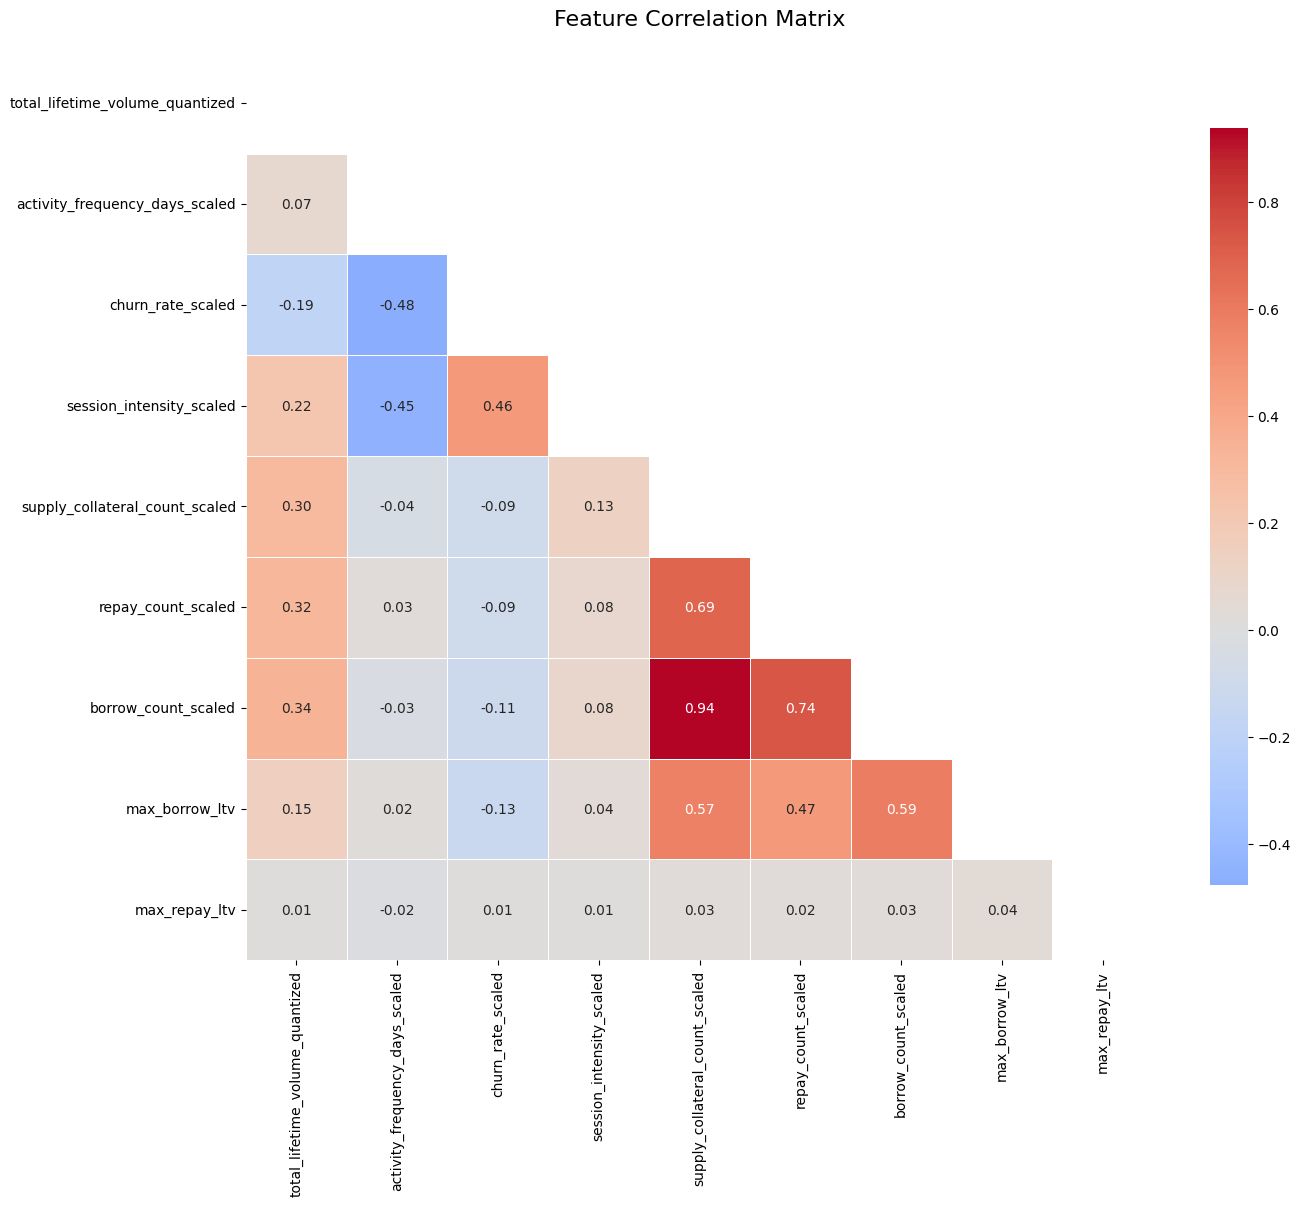

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_matrix(df, figsize=(14, 12)):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    plt.figure(figsize=figsize)
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
plot_correlation_matrix(
    transform_features(features_df).drop(columns=["user_address"])
)

Explained variance ratio: [0.35623952 0.2150315  0.11130911 0.10881744 0.06290589 0.05841418
 0.04285672 0.03818167 0.00624396]
Cumulative explained variance: [0.35623952 0.57127102 0.68258013 0.79139758 0.85430347 0.91271765
 0.95557437 0.99375604 1.        ]


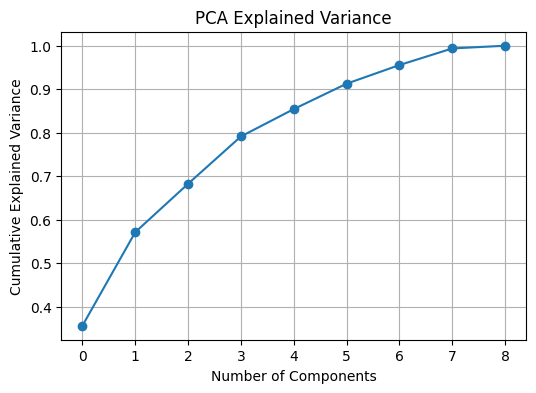

In [63]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def perform_pca(df, n_components=None):
    features = df.select_dtypes(include=[np.number])
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_features)
    
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
    
    print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
    print(f'Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}')
    
    plt.figure(figsize=(6, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.show()
    
    return pca_df, pca, scaler

transformed_df = transform_features(features_df)
features_for_clustering = transformed_df.drop(columns=["user_address"])

pca_result, pca_model, scaler = perform_pca(features_for_clustering)

component_df = pd.DataFrame(
    pca_model.components_,
    columns=features_for_clustering.columns,
    index=[f'PC{i+1}' for i in range(len(pca_model.components_))]
)

# plt.figure(figsize=(12, 8))
# sns.heatmap(component_df.iloc[:5], cmap='RdBu', center=0, annot=True, fmt='.2f')
# plt.title('Top 5 Principal Components Feature Loadings')
# plt.show()


In [64]:
pca_result.iloc[:,:10]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-2.831986,-3.123570,0.213325,-0.185414,-1.751989,1.726970,0.916753,-0.336407,0.159965
1,-2.857131,-1.268559,0.370817,-0.603375,-1.116941,-0.574183,0.405686,0.061086,0.072040
2,-2.223727,-1.160475,-0.428558,1.237699,-0.877317,-0.892859,-0.729760,-0.198147,-0.047346
3,-1.831333,0.896653,-1.102548,2.565348,-0.205197,-0.347844,0.612745,0.136965,0.081102
4,-0.852012,0.167525,0.151199,-0.154284,0.933614,-1.102675,-0.130877,-0.034054,-0.023279
...,...,...,...,...,...,...,...,...,...
623,1.216854,-1.167325,-0.163475,0.624438,0.349853,0.405743,-0.835332,0.196613,0.057298
624,0.204608,0.121151,0.202118,-0.285229,0.812662,0.455409,0.569246,0.591468,-0.011792
625,-0.151328,-0.482958,0.430537,-0.829327,0.676030,-0.009826,0.377383,-0.609865,0.280379
626,-0.998825,0.170293,0.543110,-1.042158,1.086377,-0.927980,0.251541,0.123009,0.018235


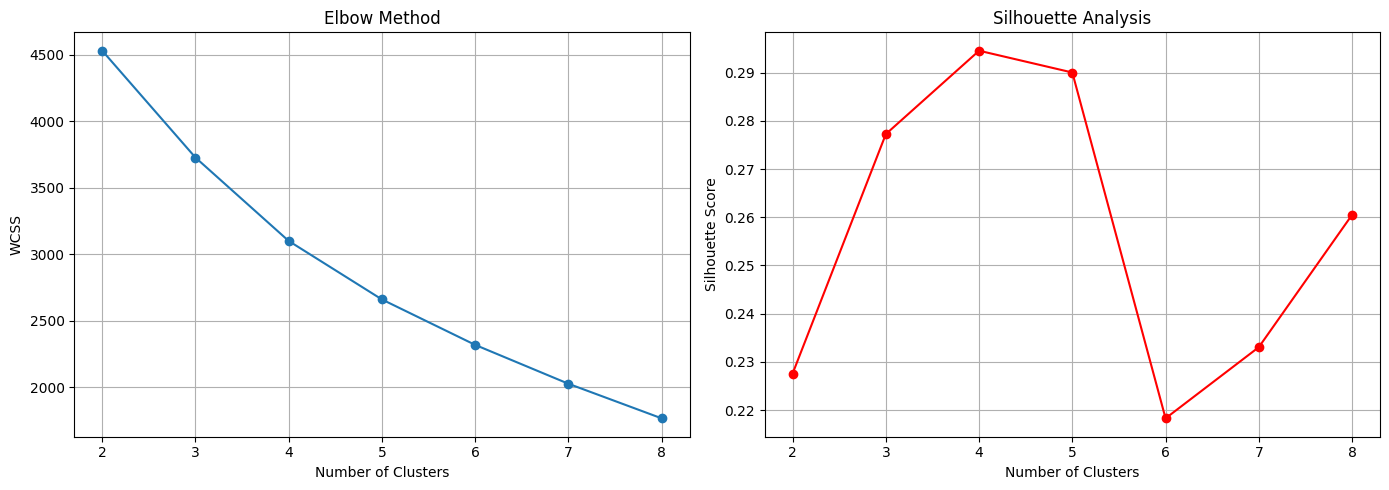

Optimal clusters suggested: 4
Optimal cluster cnt 5


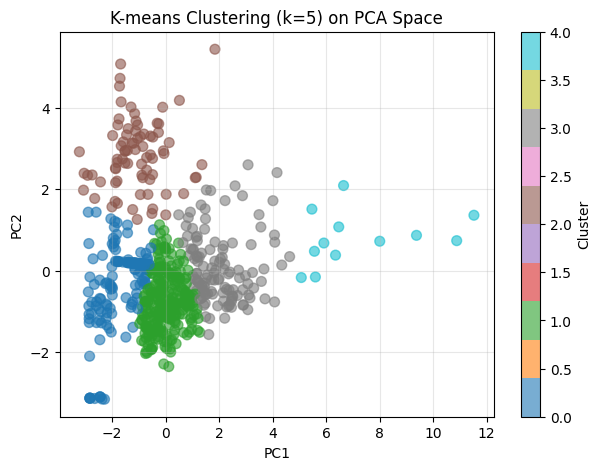

Silhouette Score: 0.372

Cluster sizes:
  Cluster 0: 158 users (25.2%)
  Cluster 1: 259 users (41.2%)
  Cluster 2: 77 users (12.3%)
  Cluster 3: 122 users (19.4%)
  Cluster 4: 12 users (1.9%)


,total_lifetime_volume,activity_frequency_days,churn_rate,session_intensity,max_borrow_ltv,max_repay_ltv,supply_collateral_count,repay_count,borrow_count
Cluster,,,,,,,,,
0,2.739136e+06,2.392087,1.632449,1.909348,0.448231,-12.923023,0.702532,0.177215,0.645570
1,5.529489e+05,12.717102,0.326873,2.043091,0.604668,0.343604,2.459459,1.637066,2.644788
2,1.379910e+08,0.072412,434.003471,6.774570,0.519158,0.157966,1.519481,0.740260,1.402597
3,1.184868e+07,3.673505,0.712654,3.101117,0.728154,0.621124,9.024590,7.967213,11.827869
4,1.412766e+07,1.267725,1.479334,3.246796,0.817138,0.784262,67.750000,44.416667,79.750000


In [72]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_optimal_clusters(pca_features, max_k=10):
    wcss = []
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(pca_features)
        wcss.append(kmeans.inertia_)
        
        if len(set(kmeans.labels_)) > 1:
            score = silhouette_score(pca_features, kmeans.labels_)
            silhouette_scores.append(score)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(range(2, max_k + 1), wcss, marker='o')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('WCSS')
    ax1.set_title('Elbow Method')
    ax1.grid(True)
    
    ax2.plot(range(2, max_k + 1), silhouette_scores, marker='o', color='red')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    optimal_k = range(2, max_k + 1)[np.argmax(silhouette_scores)]
    print(f'Optimal clusters suggested: {optimal_k}')
    
    return optimal_k

def perform_clustering(pca_features, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(pca_features)
    
    pca_with_clusters = pca_features.copy()
    pca_with_clusters['Cluster'] = cluster_labels
    
    plt.figure(figsize=(7, 5))
    
    if pca_features.shape[1] >= 2:
        scatter = plt.scatter(pca_features.iloc[:, 0], pca_features.iloc[:, 1], 
                            c=cluster_labels, cmap='tab10', alpha=0.6, s=50)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title(f'K-means Clustering (k={n_clusters}) on PCA Space')
        plt.colorbar(scatter, label='Cluster')
    else:
        plt.hist(cluster_labels, bins=n_clusters, alpha=0.7)
        plt.xlabel('Cluster')
        plt.ylabel('Frequency')
        plt.title(f'Cluster Distribution (k={n_clusters})')
    
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f'Silhouette Score: {silhouette_score(pca_features, cluster_labels):.3f}')
    
    cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
    print('\nCluster sizes:')
    for cluster, size in cluster_sizes.items():
        print(f'  Cluster {cluster}: {size} users ({size/len(cluster_labels):.1%})')
    
    return cluster_labels, kmeans

optimal_k = find_optimal_clusters(pca_result, max_k=8)
optimal_k = 5
print("Optimal cluster cnt", optimal_k)

# Perform clustering
PCA_CUTOFF = 2
cluster_labels, kmeans_model = perform_clustering(pca_result.iloc[:,:PCA_CUTOFF], n_clusters=optimal_k)

# Add clusters back to original data
prepared_df = transformed_df.copy()
prepared_df = features_df.copy()

prepared_df['Cluster'] = cluster_labels

# Analyze cluster characteristics
cluster_profiles = prepared_df.drop(columns=["user_address"]).groupby('Cluster').mean()
cluster_profiles


In [73]:
features_df_with_clusters = features_df.copy()
features_df_with_clusters["cluster"] = cluster_labels

def sample_cluster_users(df, k=5):
    if 'cluster' not in df.columns:
        print("Error: DataFrame must have 'Cluster' column")
        return
    
    clusters = sorted(df['cluster'].unique())
    
    for cluster in clusters:
        cluster_df = df[df['cluster'] == cluster]
        
        if len(cluster_df) < k:
            sample_df = cluster_df
        else:
            sample_df = cluster_df.sample(n=k, random_state=42)
        
        print(f"\n{'='*60}")
        print(f"CLUSTER {cluster} - {len(cluster_df)} users")
        print(f"{'='*60}")
        
        # Display key features for each sampled user
        for idx, row in sample_df.iterrows():
            print(f"\nUser: {row['user_address'][:10]}...")
            print(f"  Volume: ${row.get('total_lifetime_volume', 0):,.0f}")
            print(f"  Max Debt: ${row.get('max_debt_after', 0):,.0f}")
            print(f"  Max Collateral: {row.get('max_collateral_after', 9):,.5f}")
            print(f"  Borrows: {row.get('borrow_count', 0)} | Repays: {row.get('repay_count', 0)}")
            
            if 'avg_borrow_ltv' in row:
                print(f"  Avg Borrow LTV: {row['avg_borrow_ltv']:.2%}")
            
            if 'session_intensity' in row:
                print(f"  Activity: {row['session_intensity']:.1f} actions/day")
            
            if 'tenure_days' in row:
                print(f"  Tenure: {row['tenure_days']:.1f} days")
    
    # Print cluster summary
    print(f"\n{'='*60}")
    print("CLUSTER SUMMARY")
    print(f"{'='*60}")
    
    summary = df.groupby('cluster').agg({
        'total_lifetime_volume': 'mean',
        # 'max_debt_after': 'mean',
        'borrow_count': 'mean',
        # 'avg_borrow_ltv': 'mean',
        'session_intensity': 'mean',
        'user_address': 'count'
    }).round(2)
    
    summary = summary.rename(columns={'user_address': 'count'})
    print(summary)

def sample_cluster_users_detailed(df, k=3, features_to_show=None):
    if features_to_show is None:
        features_to_show = [
            'total_lifetime_volume', 'max_debt_after', 'max_collateral_after',
            'borrow_count', 'repay_count', 'supply_collateral_count',
            'avg_borrow_ltv', 'max_borrow_ltv', 'session_intensity', 'tenure_days'
        ]
    
    clusters = sorted(df['Cluster'].unique())
    
    for cluster in clusters:
        cluster_df = df[df['cluster'] == cluster]
        
        if len(cluster_df) < k:
            sample_df = cluster_df
        else:
            sample_df = cluster_df.sample(n=k, random_state=cluster)
        
        print(f"\n{'='*80}")
        print(f"CLUSTER {cluster}: {len(cluster_df)} users ({len(cluster_df)/len(df):.1%})")
        print(f"Average Characteristics:")
        
        # Show average values for this cluster
        avg_features = cluster_df[features_to_show].mean()
        for feature in features_to_show:
            if feature in avg_features:
                value = avg_features[feature]
                if 'volume' in feature or 'debt' in feature or 'collateral' in feature:
                    print(f"  {feature}: ${value:,.0f}")
                elif 'ltv' in feature:
                    print(f"  {feature}: {value:.2%}")
                elif 'count' in feature or 'intensity' in feature:
                    print(f"  {feature}: {value:.1f}")
                elif 'days' in feature:
                    print(f"  {feature}: {value:.1f} days")
        
        print(f"\nSample {k} users:")
        print("-" * 40)
        
        # Display detailed info for sampled users
        display_cols = ['user_address'] + features_to_show
        display_df = sample_df[display_cols].copy()
        
        # Format values for display
        for col in display_df.columns:
            if col == 'user_address':
                display_df[col] = display_df[col].str[:8] + '...'
            elif 'volume' in col or 'debt' in col or 'collateral' in col:
                display_df[col] = display_df[col].apply(lambda x: f"${x:,.0f}")
            elif 'ltv' in col:
                display_df[col] = display_df[col].apply(lambda x: f"{x:.1%}")
            elif 'count' in col or 'intensity' in col:
                display_df[col] = display_df[col].apply(lambda x: f"{x:.1f}")
        
        print(display_df.to_string(index=False))
        print(f"{'='*80}")

sample_cluster_users(
    features_df_with_clusters,
    k=3
)


CLUSTER 0 - 158 users

User: 0xDCD35020...
  Volume: $6,033,688
  Max Debt: $0
  Max Collateral: 9.00000
  Borrows: 0.0 | Repays: 0.0
  Activity: 4.2 actions/day

User: 0x34A491F4...
  Volume: $9,998
  Max Debt: $0
  Max Collateral: 9.00000
  Borrows: 1.0 | Repays: 0.0
  Activity: 2.0 actions/day

User: 0xb7a0c581...
  Volume: $99,994
  Max Debt: $0
  Max Collateral: 9.00000
  Borrows: 1.0 | Repays: 0.0
  Activity: 2.0 actions/day

CLUSTER 1 - 259 users

User: 0x37e83174...
  Volume: $66,490
  Max Debt: $0
  Max Collateral: 9.00000
  Borrows: 4.0 | Repays: 1.0
  Activity: 2.2 actions/day

User: 0x2D85694D...
  Volume: $1,000,803
  Max Debt: $0
  Max Collateral: 9.00000
  Borrows: 4.0 | Repays: 1.0
  Activity: 1.6 actions/day

User: 0x0d948EC2...
  Volume: $136,973
  Max Debt: $0
  Max Collateral: 9.00000
  Borrows: 1.0 | Repays: 1.0
  Activity: 2.0 actions/day

CLUSTER 2 - 77 users

User: 0x0d0fc47B...
  Volume: $2
  Max Debt: $0
  Max Collateral: 9.00000
  Borrows: 1.0 | Repays: 1.0
